In [36]:
import pandas as pd

In [79]:
def read_policy_vectors():
    df = pd.read_excel('../../Data/b_guns_17 .xlsx')
    
    rt = {}

    for idx, row in df.iterrows():
        if idx == 0:
            continue

        state = row['State']

        if state not in rt:
            rt[state] = {}

        year = row['Year']

        policy_vector = row.tolist()[2:]

        rt[state][year] = policy_vector
        
    return rt

In [139]:
def find_policies_for_rct(policy_vectors, year):
    year = 2014
    meta_matching = {}
    meta_mismatching = {}

    states = list(policy_vectors.keys())

    for i in range(len(states)):
        
        s1 = states[i]
        state_pairs = states[i+2:]

        for j in range(len(state_pairs)):
            s2 = state_pairs[j]
            s1_vector = policy_vectors[s1][year]
            s2_vector = policy_vectors[s2][year]

            # find matches & mismatches
            matches, mis_matches = find_matches(s1_vector, s2_vector)
                        
            # add to meta stores
            if s1 not in meta_matching:
                meta_matching[s1] = {}
                
            if s1 not in meta_mismatching:                
                meta_mismatching[s1] = {}
            
            meta_matching[s1][s2] = matches
            meta_mismatching[s1][s2] = mis_matches
            
    return meta_matching, meta_mismatching
    

### Now. There are 47 policy levers. When given 2 policy vectors, we need to figure out
- Which policies they have in common
- Which policies they do not have in common 

In [81]:
def find_matches(s1_vector, s2_vector):
    '''
    Returns matching and unmatching policies for 2 states. 
    '''
    n_policies = len(s1_vector)
    assert len(s1_vector) == len(s2_vector)
    
    matches = {}
    
    mis_matches = {}
    
    for p in range(n_policies):
        s1_policy = s1_vector[p]
        s2_policy = s2_vector[p]
        
        if s1_policy == s2_policy:
            matches[p] = True         
        else:
            mis_matches[p] = True
    
    return matches, mis_matches

In [77]:
len(mis_matches)/len(matches)

0.46875

### Now we know which policies they have in common versus not. Let's store this information, and see how it scales across all of the states. 
If we virtually NEVER have a single policy difference, then we'll know we need to make a cutoff.
Otherwise, we'll shoot for examples that have a single policy difference.

In [140]:
policy_vectors = read_policy_vectors()
meta_matching, meta_mismatching = find_policies_for_rct(policy_vectors, 2014)
total_matches, total_mismatches = find_total_matches(meta_matching, meta_mismatching)

In [98]:
def find_total_matches(meta_matching, meta_mismatching):

    total_matches = {}
    total_mismatches = {}

    dicts = [meta_matching, meta_mismatching]

    for i, d in enumerate(dicts):

        for s1 in d.keys():

            for s2 in d[s1].keys():

                for k,v in d[s1][s2].items():
                    if i == 0:

                        if k not in total_matches:
                            total_matches[k] = 1
                        else:
                            total_matches[k] += 1

                    else:
                        if k not in total_mismatches:
                            total_mismatches[k] = 1
                        else:
                            total_mismatches[k] += 1
                            
    return total_matches, total_mismatches

### Now, let's get a histogram with matching vs unmatched policies across all states
In 2014, that is

In [141]:
matching_keys = sorted(list(total_matches.keys()))
mismatching_keys = sorted(list(total_mismatches.keys()))

In [149]:
def get_ys(keys, d):
    rt = []
    for k in keys:
        rt.append(d[k]/50)
    return rt

matching_ys = get_ys(matching_keys, total_matches)
mismatching_ys = get_ys(mismatching_keys, total_mismatches)

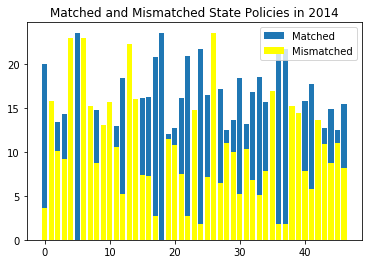

In [151]:
%matplotlib inline

from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
plt.bar(matching_keys, matching_ys)
plt.bar(mismatching_keys, mismatching_ys, color='yellow')
plt.title('Matched and Mismatched State Policies in 2014')
plt.legend(['Matched', 'Mismatched'])
plt.show()

## Based on this sample, it looks like at a minimum, we'd need two states to have only 13 policies that are different.
Best case scenario appears to be a maximum of 5 policies that are not shared, but this is very rare. 

In [127]:
def find_valid_experiments(total_mismatches):
    states = list(total_mismatches.keys())

In [170]:
valid_rcts = {}

states = list(meta_mismatching.keys())

for s1 in meta_mismatching.keys():
    
    for s2 in meta_mismatching[s1].keys():
        
        n_mismatched = len(meta_mismatching[s1][s2])
        
        if n_mismatched <= 13:
            
            if s1 not in valid_rcts:
                valid_rcts[s1] = []
            
            valid_rcts[s1].append([s2, meta_mismatching[s1][s2]])

In [192]:
import csv

with open('../../Data/valid_rcts_2014.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Treatment State', 'Control State', "Policy ID's for RCT"])
    
    for s1 in valid_rcts.keys():
        for each in valid_rcts[s1]:
            s2 = each[0]
            policies = list(each[1].keys())
    
            writer.writerow([s1, s2, policies])

Given this criteria, of having a maximum of 13 policy levers that are different between 2 states in order to run an RCT, it seems we only have 31 states where we can reasonably run the analysis. 

I'm ok with that for now. Eventually we can target the juicy states that are totally different from others, but for now let's focus on the ones that fit this research agenda.

We also need to include the actual policies for the 31 states in these RCTs. The polciy levers are what Pareto is searching for